In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
#from models.sub_tcn import Sub_TCN
from models.gru import GRU

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
clust_mode = "hand"
model_type = "gru"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)

if (clust_mode == "hand") or (clust_mode == "whole"):
    C_syn_e = np.load("/media/hdd01/sklee/"+cell_type+"_"+experiment+"/data/handsub10_C_syn_e.npy")
    C_syn_i = np.load("/media/hdd01/sklee/"+cell_type+"_"+experiment+"/data/handsub10_C_syn_i.npy")
    C_syn_e = torch.from_numpy(C_syn_e).float()
    C_syn_i = torch.from_numpy(C_syn_i).float()
elif clust_mode == "rand":
    C_syn_e = np.load("/media/hdd01/sklee/"+cell_type+"_"+experiment+"/data/randsub10_C_syn_e.npy")
    C_syn_i = np.load("/media/hdd01/sklee/"+cell_type+"_"+experiment+"/data/randsub10_C_syn_i.npy")
    C_syn_e = torch.from_numpy(C_syn_e).float()
    C_syn_i = torch.from_numpy(C_syn_i).float()

In [3]:
H_no = 20
sub_no = 10
E_no = 2000
I_no = 200
T_no = 500
device = torch.device("cuda")

In [4]:
if model_type == "gru":
    model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
elif model_type == "tcn":
    model = Sub_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
elif model_type == "glm":
    model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
    
model.to(device).float()
model.load_state_dict(torch.load(base_dir+cell_type+"_"+experiment+"/"+clust_mode+"/"+model_type+"_s"+str(sub_no)+"_h"+str(H_no)+".pt", map_location='cuda:0'))
model.eval()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

16211


In [5]:
trial_no = 980

if model_type == "gru":
    test = np.zeros((trial_no,50000))
    sub_out = np.zeros((trial_no, sub_no, 50000))

    for i in tnrange(trial_no):
        part_E_neural = torch.from_numpy(E_neural[i*50000:(i+1)*50000].toarray()).to(device).float().unsqueeze(0)
        part_I_neural = torch.from_numpy(I_neural[i*50000:(i+1)*50000].toarray()).to(device).float().unsqueeze(0)

        part_test, part_sub_out = model(part_E_neural, part_I_neural)
        test[i] = part_test.cpu().detach().numpy().flatten()
        sub_out[i] = part_sub_out.squeeze(0).T.cpu().detach().numpy()
        
    E_scale = np.exp(model.E_scale.cpu().detach().numpy())
    np.savez(base_dir+cell_type+"_"+experiment+"/"+clust_mode+"/"+model_type+"_s"+str(sub_no)+"_h"+str(H_no)+"_extra_output.npz",
        test=test,
        sub_out=sub_out,
        E_scale = E_scale)
    
elif model_type == "glm":
    test = np.zeros((trial_no,50000))
    nonlin_in = np.zeros((trial_no0,sub_no,H_no, 50000))
    sub_out = np.zeros((trial_no, sub_no, 50000))
    
    for i in tnrange(trial_no):
        part_E_neural = torch.from_numpy(E_neural[i*50000:(i+1)*50000].toarray()).to(device).float().unsqueeze(0)
        part_I_neural = torch.from_numpy(I_neural[i*50000:(i+1)*50000].toarray()).to(device).float().unsqueeze(0)

        part_test, part_sub_out, part_nonlin_in = model(part_E_neural, part_I_neural)
        test[i] = part_test.cpu().detach().numpy().flatten()
        sub_out[i] = part_sub_out.squeeze(0).T.cpu().detach().numpy()
        nonlin_in[i] = part_nonlin_in.squeeze(0).reshape(sub_no, H_no, -1).cpu().detach().numpy()
        
    cos_basis_no = 30
    scale = 7.5
    shift = 1
        
    kern_basis = torch.zeros(cos_basis_no, T_no).to(device)
    for i in range(cos_basis_no):
        phi = 1.5707963267948966*i
        xmin = phi - 3.141592653589793
        xmax = phi + 3.141592653589793

        x_in = torch.arange(0, T_no, 1)
        raw_cos = scale  * torch.log(x_in + shift + 1e-7)

        basis = 0.5*torch.cos(raw_cos - phi) + 0.5
        basis[raw_cos < xmin] = 0.0
        basis[raw_cos > xmax] = 0.0
        kern_basis[i] = basis
        
    e_kern = torch.matmul(model.W_e_layer1, kern_basis).reshape(sub_no, H_no, T_no).cpu().detach().numpy()
    i_kern = torch.matmul(model.W_i_layer1, kern_basis).reshape(sub_no, H_no, T_no).cpu().detach().numpy()
    
    E_scale = np.exp(model.E_scale.cpu().detach().numpy())
    np.savez(base_dir+cell_type+"_"+experiment+"/"+clust_mode+"/"+model_type+"_s"+str(sub_no)+"_h"+str(H_no)+"_extra_output.npz",
        test=test,
        nonlin_in=nonlin_in,
        sub_out=sub_out,
        e_kern=e_kern,
        i_kern=i_kern,
        E_scale=E_scale)

<ipython-input-5-967f45047999>:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(trial_no):


  0%|          | 0/980 [00:00<?, ?it/s]

In [5]:
final_test = np.zeros((8,3,30,6000))

syn_list = [25,630,1432,1895]

for i in tnrange(8):
    if i == 0:
        syn = 930
    elif i == 1:
        syn = 990
    elif i == 2:
        syn = 1050
    elif i == 3:
        syn = 1110
    else:
        syn = syn_list[i-4]
    
    for j in range(3):
        for k in range(30):
            E_in = torch.zeros(1,6000,2000).cuda()
            I_in = torch.zeros(1,6000,200).cuda()
            
            if j == 0:
                spk_times = np.arange(500,500+10*(k+1),10)
            elif j == 1:
                spk_times = np.arange(500,500+50*(k+1),50)
            elif j == 2:
                spk_times = np.arange(500,500+150*(k+1),150)
            
            E_in[0, spk_times ,syn] = 1
            test, sub_out = model(E_in, I_in)
            final_test[i,j,k] = test.cpu().detach().numpy()

<ipython-input-5-2e5a31e48435>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(8):


  0%|          | 0/8 [00:00<?, ?it/s]

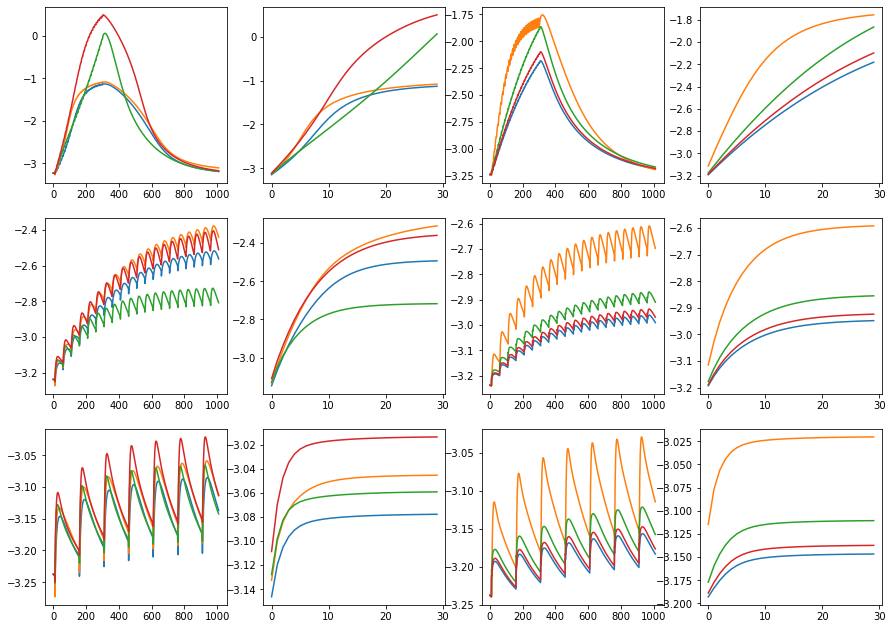

In [7]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize = (15,11))

for i in range(3):
    for j in range(4):
            axs[i,0].plot(final_test[j,i,-1,490:1500])
            axs[i,1].plot(np.max(final_test[j,i,:,490:], 1))
            
            axs[i,2].plot(final_test[j+4,i,-1,490:1500])
            axs[i,3].plot(np.max(final_test[j+4,i,:,490:], 1))

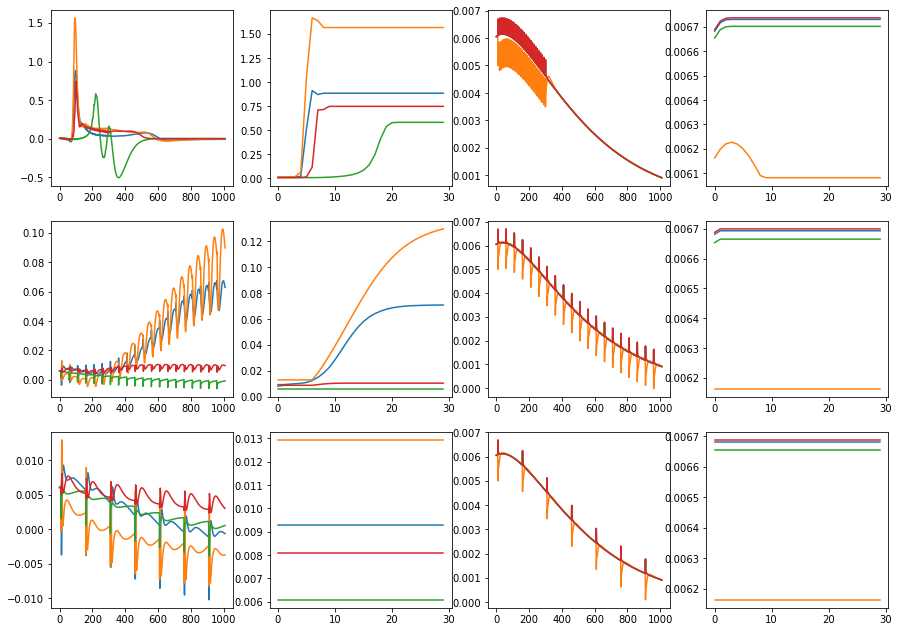

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize = (15,11))

for i in range(3):
    for j in range(4):
            axs[i,0].plot(final_test[j,i,-1,490:1500])
            axs[i,1].plot(np.max(final_test[j,i,:,490:], 1))
            
            axs[i,2].plot(final_test[j+4,i,-1,490:1500])
            axs[i,3].plot(np.max(final_test[j+4,i,:,490:], 1))

In [8]:
#np.save("/media/hdd01/sklee/CA1_clust4-60_noNA/hand/gru_s10_h20_probe.npy", final_test)